# Homework 2

## 1. Eigenface for face recognition

#### Set Up

In [1]:
# import libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import imageio

%matplotlib inline

#### a) Download the faces dataset

#### b) Load train/test dataset and show examples

In [2]:
# lists to store training data and its labels
train_labels, train_data = [], []

# read training data and store in the correct format
# taken from the example code in homework-2.pdf 
# using "with" syntax to close the file when complete
with open('faces/train.txt', 'r') as f:
    for line in f:
        im = imageio.imread(line.strip().split()[0])
        train_data.append(im.reshape(2500,))
        train_labels.append(line.strip().split()[1])  
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

# print array dimensions
print (train_data.shape, train_labels.shape) 

(540, 2500) (540,)


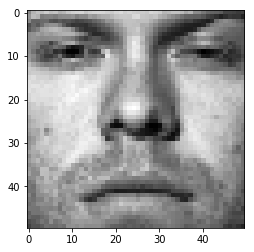

In [3]:
# show one grayscale image from training data
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r);

In [4]:
# lists to store test data and its labels
test_labels, test_data = [], []

# read test data and store in the correct format
# taken from the example code in homework-2.pdf 
# using "with" syntax to close the file when complete
with open('faces/test.txt', 'r') as f:
    for line in f:
        im = imageio.imread(line.strip().split()[0])
        test_data.append(im.reshape(2500,))
        test_labels.append(line.strip().split()[1])  
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

# print array dimensions
print (test_data.shape, test_labels.shape) 

(100, 2500) (100,)


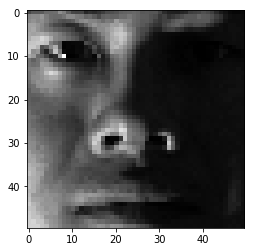

In [5]:
# show one grayscale image from testing data
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r);

#### c) Find average face in training data

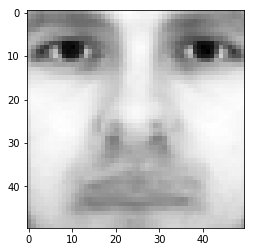

In [6]:
# calculate the average face
trainFaceAv = np.sum(train_data, axis=0)/540 

# display the average face image
plt.imshow(trainFaceAv.reshape(50,50), cmap = cm.Greys_r);

#### d) Mean Subtraction

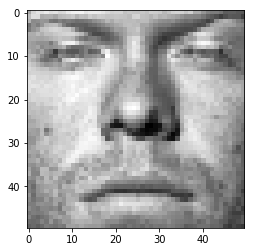

In [7]:
# subtract average face from training data
trainMinusAv = train_data - trainFaceAv

# show one of the resulting images
plt.imshow(trainMinusAv[10, :].reshape(50,50), cmap = cm.Greys_r);

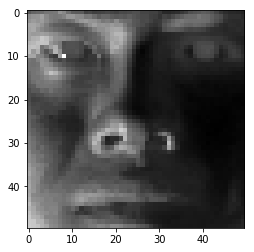

In [8]:
# subtract average face from testing data
testMinusAv = test_data - trainFaceAv 

# show one of the resulting images
plt.imshow(testMinusAv[10, :].reshape(50,50), cmap = cm.Greys_r);

#### e) Eigenface

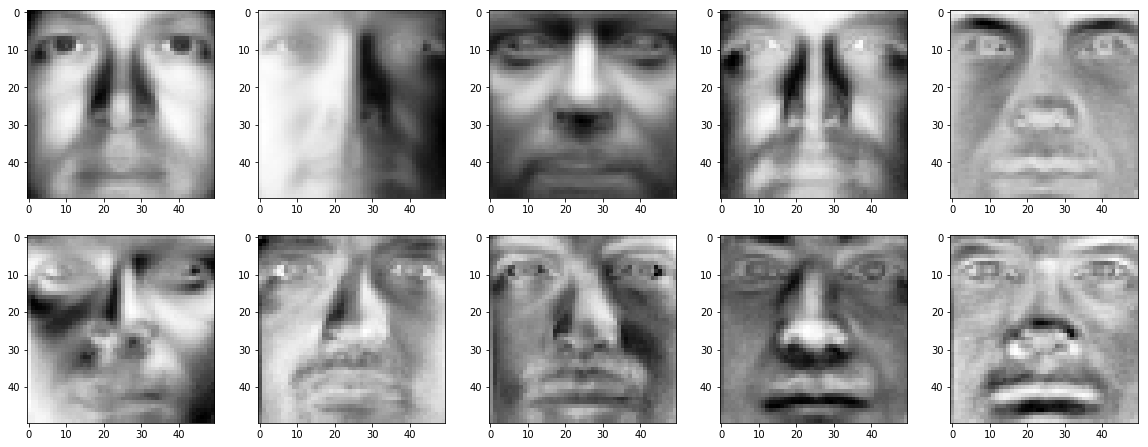

In [9]:
# perform Singular Value Decomposition (SVD) on the training data
U, S, VTrans = sp.linalg.svd(trainMinusAv) # change to train_data????

plt.figure(figsize=(20,20)) 

# display the first 10 images in V Transpose (VTrans)
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.imshow(VTrans[i, :].reshape(50,50), cmap = cm.Greys_r) 

#### f) Low rank approximation

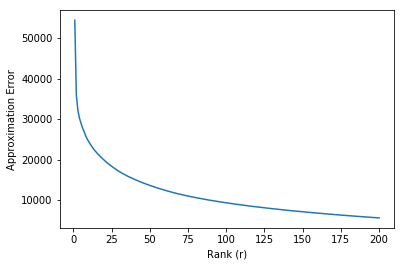

In [10]:
# r is r=1,2,...,200
rValues = [n for n in range(1, 201)]
# list to store Frobenius Norm error values
errList = []

# calculate the low rank approximation error for every rank in r=[1,200]
for r in rValues: 
    # calculate matrix products
    SVt_product = np.dot(np.diag(S[:r]), VTrans[:r,:])
    Xr = np.dot(U[:,:r], SVt_product) 
    # calculate difference between X and Xr
    diff = np.subtract(trainMinusAv, Xr) # change to train_data????
    # calculate Frobenius Norm of the difference
    errList.append(np.linalg.norm(diff, 'fro'))

# plot r against error
plt.plot(rValues, errList, label='Rank-r Approximation Error') 
plt.xlabel("Rank (r)") 
plt.ylabel("Approximation Error");

#### g) Eigenface Feature

In [11]:
def generateFMatrix(trainImgs, testImgs, r):
    ''' 
    Function to generate Eigenface feature (F) matrices for the training and testing data.
    Takes parameters:
        trainImgs: training images, 
        testImgs: testing images, 
        r: Rank
    '''
    
    # calculate F matrix for training data
    F_train = np.dot(trainImgs, np.transpose(VTrans[:r, :])) 
    
    # calculate F matrix for testing data
    F_test = np.dot(testImgs, np.transpose(VTrans[:r, :])) 
    
    return F_train, F_test 

In [12]:
# test the correct functioning of the generateFMatrix function
FMatrices = generateFMatrix(trainMinusAv, testMinusAv, 20)
print(FMatrices[0].shape)
print(FMatrices[1].shape)

(540, 20)
(100, 20)


#### h) Face Recognition

In [13]:
# Get training and test features for r = 10
train10, test10 = generateFMatrix(trainMinusAv, testMinusAv, 10) 

# create a logistic regression model
lr = LogisticRegression(multi_class = 'ovr').fit(train10, train_labels)
# get predictions
preds = lr.predict(test10) 

# calculate and print model accuracy
accuracy = metrics.accuracy_score(preds, test_labels) * 100
print('The accuracy of our model for r = 10 is', accuracy, '%') 

The accuracy of our model for r = 10 is 79.0 %


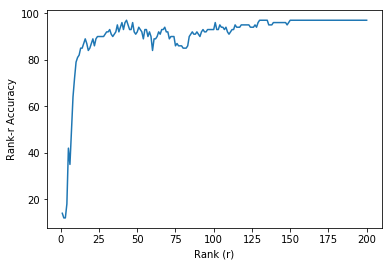

In [14]:
accuracies = [] # list to store accuracies for r = 1,....,200

for r in rValues:
    # get matrices
    trainF, testF = generateFMatrix(trainMinusAv, testMinusAv, r) 
    # create logistics regression model
    lr = LogisticRegression(multi_class = 'ovr').fit(trainF, train_labels)
    # predict
    preds = lr.predict(testF) 
    # find accuracy
    accuracies.append(metrics.accuracy_score(test_labels, preds)*100) 

# create accuracy plot, plotting r against accuracy
plt.plot(rValues, accuracies, label='Classification Accuracy') 
plt.xlabel("Rank (r)") 
plt.ylabel("Rank-r Accuracy"); 

## 2. What's Cooking?

#### Set Up

In [14]:
# import libraries needed for this question
import json
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import KFold
import pandas as pd

#### a) Joined What's Cooking competition on Kaggle

#### b) About the training data

In [3]:
# load train data
with open('cooking/train.json', 'r') as train_file:
    train_data = json.load(train_file)

# load test data
with open('cooking/test.json', 'r') as test_file:
    test_data = json.load(test_file)

In [4]:
# how many dish samples do we have
length = len(train_data)
print('There are', length, 'samples (dishes) in the training dataset.')


# how many cuisine types do we have
# create a list of cuisine labels
cuisine_labels = [dish['cuisine'] for dish in train_data]
# a set will never add a cuisine type more than once so we can use it to find unique values
cuisineTypes = set([cuisine for cuisine in cuisine_labels])   
numCuisines = len(cuisineTypes)
print('There are', numCuisines, 'cuisines in the training dataset.')


# how many unique ingredients do we have
ingredientTypes = set()
for dish in train_data:
    for ingredient in dish['ingredients']:
        ingredientTypes.add(ingredient)
numIngredients = len(ingredientTypes)

# have a list of unqiue ingredients
ingredientTypes = list(ingredientTypes)

print('There are', numIngredients, 'unique ingredients in the training dataset.')

There are 39774 samples (dishes) in the training dataset.
There are 20 cuisines in the training dataset.
There are 6714 unique ingredients in the training dataset.


#### c) Dish Representation by Ingredients

In [5]:
# create the training feature matrix
train_feature_matrix = [] # initialize matrix

for dish in train_data:
    # find the dish features
    # checking if each ingredient in the ingredient list is an ingredient of the dish
    dishFeatures = [1 if ingredient in dish['ingredients'] else 0 for ingredient in ingredientTypes]
    # add this dish to the feature matrix
    train_feature_matrix.append(dishFeatures)

In [6]:
# check if it is n x d, where n is number of samples and d is number of ingredients
print(np.shape(train_feature_matrix))

(39774, 6714)


##### Find dish representation for test data as well

In [7]:
# create the testing feature matrix
test_feature_matrix = [] # initialize matrix

for dish in test_data:
    # find the dish features
    # checking if each ingredient in the ingredient list is an ingredient of the dish
    dishFeatures = [1 if ingredient in dish['ingredients'] else 0 for ingredient in ingredientTypes]
    # add this dish to the feature matrix
    test_feature_matrix.append(dishFeatures)

#### d) Naive Bayes Classification

In [8]:
cv = KFold(n_splits = 3) # initialize a crossvalidation splitter
X = np.array(train_feature_matrix) # set x values to feature matrix
Y = np.array(cuisine_labels) # set y values to labels

# initialize accuracy lists
gauss_accs = [] 
bern_accs = []

# crossvalidation
for train, test in cv.split(X, Y):
    # initialize naive bayes models for gaussian and bernoulli prior options
    gnb = GaussianNB()
    bnb = BernoulliNB()
    
    # fit both naive bayes models 
    gnb.fit(X[train], Y[train])
    bnb.fit(X[train], Y[train])
    
    # predict the cusine for the test set
    gauss_preds = gnb.predict(X[test])
    bern_preds = bnb.predict(X[test])
    
    # add accuracy of predictions to the accuracy list
    gauss_accs = metrics.accuracy_score(gauss_preds, Y[test])
    bern_accs = metrics.accuracy_score(bern_preds, Y[test])
    
# calculate the average accuracy for each of the gaussian and bernoulli prior options
gauss_avg_accuracy = np.mean(gauss_accs) * 100
bern_avg_accuracy = np.mean(bern_accs) * 100

print('The average accuracy of the model with a Gaussian prior with 3-fold crossvalidation is', 
      gauss_avg_accuracy, '%.')
print('The average accuracy of the model with a Bernoulli prior with 3-fold crossvalidation is', 
      bern_avg_accuracy, '%.')

The average accuracy of the model with a Gaussian prior with 3-fold crossvalidation is 37.758334590435965 %.
The average accuracy of the model with a Bernoulli prior with 3-fold crossvalidation is 68.69060190073918 %.


#### e) Which prior performs better?

The Bernoulli prior Naive Bayes classifier works better. Explaination in report.

#### f) Logistic Regression

In [9]:
cv = KFold(n_splits = 3) # initialize a crossvalidation splitter
lr_accs = [] # initialize accuracy list

# crossvalidation
for train, test in cv.split(X, Y):
    # create and fit logistic regression model
    lr = LogisticRegression().fit(X[train], Y[train])
    
    # predict the cusine for the test set
    lr_preds = lr.predict(X[test])   
    
    # add accuracy of predications to the accuracy list
    lr_accs = metrics.accuracy_score(lr_preds, Y[test])
    
# calculate the average accuracy for each of the gaussian and bernoulli prior options
lr_avg_accuracy = np.mean(lr_accs) * 100

print('The average accuracy of the logistic regression model with 3-fold crossvalidation is', 
      lr_avg_accuracy, '%.')

The average accuracy of the logistic regression model with 3-fold crossvalidation is 77.86996530396742 %.


#### g) Train Best Classifier with all Test Data

In [11]:
# initialize best classifier
best_classifier = LogisticRegression()

# fit best classifier to test data
best_classifier.fit(train_feature_matrix, cuisine_labels)

# find predictions on test data
final_preds = best_classifier.predict(test_feature_matrix)

In [12]:
# create list of test sample ids
test_ids = [sample['id'] for sample in test_data]

In [18]:
# save test predictions to file
answer_df = pd.DataFrame(list(zip(test_ids, final_preds)), columns = ['id', 'cuisine'])
answer_df.to_csv('Cooking_Results_v1.csv', index=False)